Pontifícia Universidade Católica de São Paulo 

`Ciência de Dados e Inteligência Artificial`

## Laboratório 12 - Clustering hierárquico


---
> 👨‍🏫*Professor Dr. Rooney Coelho (rracoelho@pucsp.br)*
---


## Descrição do problema

Imagine que um fabricante de automóveis tenha desenvolvido protótipos para um novo veículo. Antes de introduzir o novo modelo em sua gama, o fabricante quer determinar quais veículos existentes no mercado são mais parecidos com os protótipos - ou seja, como os veículos podem ser agrupados, qual grupo é mais semelhante ao modelo e, portanto, quais modelos eles estarão competindo contra.

Nosso objetivo aqui é usar métodos de agrupamento, para encontrar os agrupamentos mais distintos de veículos. Ele resumirá os veículos existentes e ajudará a manufatura a tomar decisões sobre novos modelos de maneira simples.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler # Normalização
from scipy.spatial import distance_matrix # Cálculo da matriz de distâncias
from scipy.cluster import hierarchy # Cluster hierárquico

Carregue o arquivo disponível em https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cars_clus.csv e armazene em df.

In [17]:
df = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cars_clus.csv')
df

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,Volvo,V70,17.531,$null$,0.000,28.800,2.400,168.000,104.900,69.300,186.200,3.259,17.900,25.000,2.864,0.0
155,Volvo,C70,3.493,$null$,0.000,45.500,2.300,236.000,104.900,71.500,185.700,3.601,18.500,23.000,1.251,0.0
156,Volvo,S80,18.969,$null$,0.000,36.000,2.900,201.000,109.900,72.100,189.800,3.600,21.100,24.000,2.943,0.0
157,NaN,newCar,$null$,$null$,$null$,21.500,1.500,76.000,106.300,67.900,175.000,2.932,11.900,46.000,$null$,1.0


### 1) Limpeza dos dados

Execute `df.dtypes` para checar o tipo dos dados.

In [18]:
df.dtypes

manufact      object
model         object
sales         object
resale        object
type          object
price         object
engine_s      object
horsepow      object
wheelbas      object
width         object
length        object
curb_wgt      object
fuel_cap      object
mpg           object
lnsales       object
partition    float64
dtype: object

Note que a maioria das colunas não contém valores numéricos e estão como texto e é necessário fazer uma limpeza desses dados para remover os não nulos.

Use o seguinte exemplo como base para converter as colunas de texto para numéricas. Faça isso para todas as colunas após `sales`.
```
df.iloc[:,2] = df.iloc[:,2].apply( pd.to_numeric, errors='coerce' )
```

In [23]:
df.replace("$null$", np.nan, inplace=True)

for col in df.columns[2:]:
    df[col] = df[col].astype('float64')

df.dtypes

manufact      object
model         object
sales        float64
resale       float64
type         float64
price        float64
engine_s     float64
horsepow     float64
wheelbas     float64
width        float64
length       float64
curb_wgt     float64
fuel_cap     float64
mpg          float64
lnsales      float64
partition    float64
dtype: object

Uma vez que você atribuiu `NaN` para os dados faltantes use o método `dropna()` do seu Dataframe para remover as linhas que contém dados faltantes. Use em seguida o método `reset_index(drop=True)` para corrigir a numeração.

In [24]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,Volkswagen,Golf,9.761,11.425,0.0,14.90,2.0,115.0,98.9,68.3,163.3,2.767,14.5,26.0,2.278,0.0
113,Volkswagen,Jetta,83.721,13.240,0.0,16.70,2.0,115.0,98.9,68.3,172.3,2.853,14.5,26.0,4.427,0.0
114,Volkswagen,Passat,51.102,16.725,0.0,21.20,1.8,150.0,106.4,68.5,184.1,3.043,16.4,27.0,3.934,0.0
115,Volkswagen,Cabrio,9.569,16.575,0.0,19.99,2.0,115.0,97.4,66.7,160.4,3.079,13.7,26.0,2.259,0.0


Confira que a operação foi bem sucedida usando `df.isna().any()`. Ainda há algum dado faltante no DataFrame?

In [25]:
df.isna().any()

manufact     False
model        False
sales        False
resale       False
type         False
price        False
engine_s     False
horsepow     False
wheelbas     False
width        False
length       False
curb_wgt     False
fuel_cap     False
mpg          False
lnsales      False
partition    False
dtype: bool

### 2) Atribuição das features

Para a nossa classificação use come features as seguintes colunas do Dataset:


* 'engine_s'  
* 'horsepow' 
* 'wheelbas' 
* 'width' 
* 'length' 
* 'curb_wgt' 
* 'fuel_cap' 
* 'mpg'



In [26]:
feature_names = ['engine_s', 'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg']
features = df[feature_names]

### 3) Normalização dos dados

Use o método `fit_transform()` da do objeto `MinMaxScaler()` que foi importado para a normalzação dos dados entre 0-1.

In [27]:
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

### 4) Cluster hierárquico

Para fazer o agrupamento dos dados use a biblioteca Scipy. Antes de tudo calcule a matriz de distâncias usando a função `distance_matrix()` que foi importada no cabeçalho do caderno. 

In [29]:
dist_matrix = distance_matrix(features, features)
dist_matrix

array([[0.        , 0.57777143, 0.75455727, ..., 0.28530295, 0.24917241,
        0.18879995],
       [0.57777143, 0.        , 0.22798938, ..., 0.36087756, 0.66346677,
        0.62201282],
       [0.75455727, 0.22798938, 0.        , ..., 0.51727787, 0.81786095,
        0.77930119],
       ...,
       [0.28530295, 0.36087756, 0.51727787, ..., 0.        , 0.41797928,
        0.35720492],
       [0.24917241, 0.66346677, 0.81786095, ..., 0.41797928, 0.        ,
        0.15212198],
       [0.18879995, 0.62201282, 0.77930119, ..., 0.35720492, 0.15212198,
        0.        ]])

No agrupamento aglomerativo, a cada iteração, o algoritmo deve atualizar a matriz de distância para refletir a distância do cluster recém-formado com os clusters restantes. Os seguintes métodos são suportados no Scipy para calcular a distância entre o cluster recém-formado e cada um: único, completo, médio, ponderado, centróide.

Agora que você calculou a matriz de distâncias configure a função de ligamento entre clusters `linkage` como do tipo `complete`. Use a biblioteca hierachy do scipy para isso. Usamos o completo em nosso caso, mas fique à vontade para alterá-lo para ver como os resultados mudam.

In [31]:
Z = hierarchy.linkage(dist_matrix, 'complete')

/tmp/ipykernel_30322/2263504671.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(dist_matrix, 'complete')


Gere agora o dendrograma para o cluster hierárquico que você acabou de caluclar. Salve a figura como `dendro.pdf` usando o método `savefig` do pyplot. Analise o arquivo gerado e veja as relações.

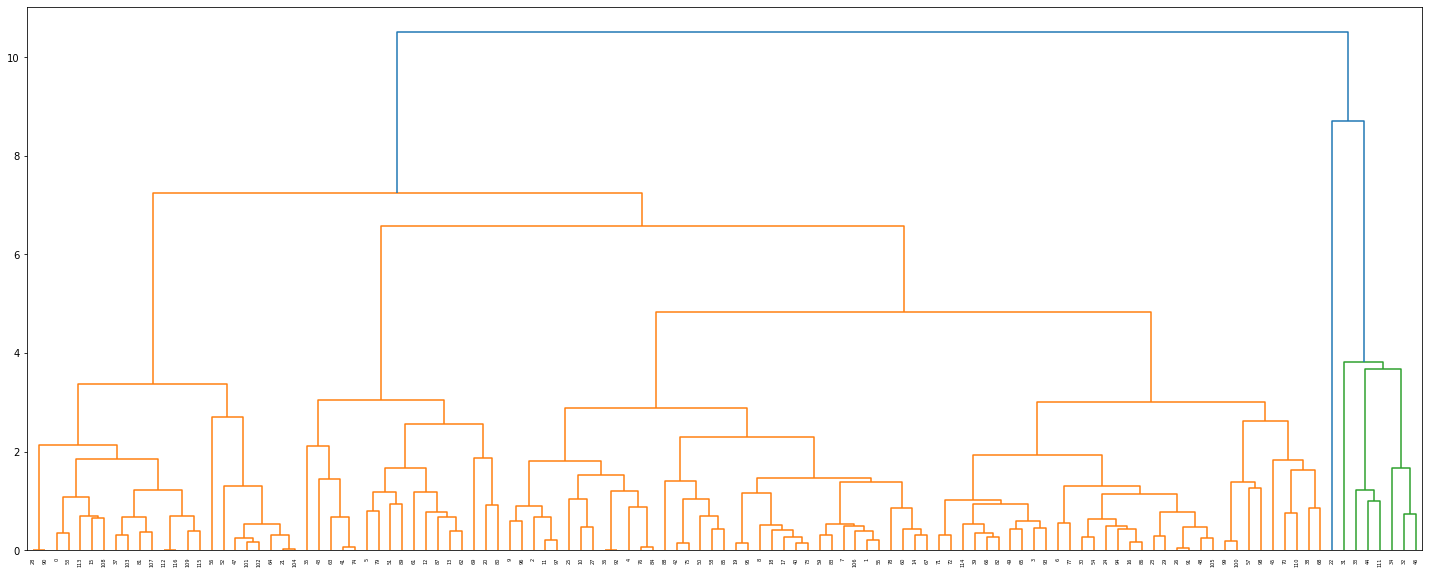

In [32]:
plt.figure(figsize=(25, 10))
dn = hierarchy.dendrogram(Z)
plt.savefig('dendro.pdf')

Essencialmente, o clustering hierárquico não requer um número pré-especificado de clusters. No entanto, em alguns aplicativos, queremos uma partição de clusters separados, assim como no cluster simples. Então você pode usar uma linha de corte, execute o código a seguir para isso.

```python
from scipy.cluster.hierarchy import fcluster
k = 5 # número de clusters
clusters = fcluster(Z, k, criterion='maxclust')
clusters
```

In [33]:
from scipy.cluster.hierarchy import fcluster
k = 5 # número de clusters
clusters = fcluster(Z, k, criterion='maxclust')
clusters

array([1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 1, 3, 3, 3, 3, 2, 1,
       5, 3, 3, 3, 3, 3, 1, 3, 3, 4, 4, 4, 4, 2, 3, 1, 3, 3, 3, 2, 3, 2,
       4, 3, 4, 1, 3, 3, 3, 2, 1, 1, 3, 3, 1, 3, 3, 3, 3, 2, 2, 2, 1, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 1, 3, 3, 3, 3, 3, 2,
       3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1,
       3, 4, 1, 1, 3, 1, 1], dtype=int32)

Adicione esses grupos recém criados a uma nova coluna do DataFrame original.

In [34]:
df['cluster'] = clusters
df

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition,cluster
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0,1
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0,3
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0,3
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0,3
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,Volkswagen,Golf,9.761,11.425,0.0,14.90,2.0,115.0,98.9,68.3,163.3,2.767,14.5,26.0,2.278,0.0,1
113,Volkswagen,Jetta,83.721,13.240,0.0,16.70,2.0,115.0,98.9,68.3,172.3,2.853,14.5,26.0,4.427,0.0,1
114,Volkswagen,Passat,51.102,16.725,0.0,21.20,1.8,150.0,106.4,68.5,184.1,3.043,16.4,27.0,3.934,0.0,3
115,Volkswagen,Cabrio,9.569,16.575,0.0,19.99,2.0,115.0,97.4,66.7,160.4,3.079,13.7,26.0,2.259,0.0,1
